# Customer segmentation based on RFM variables using K-means

# Business Understanding

How much does it cost to acquire new customers versus the cost to retain existing ones? Retaining customers is as important as acquiring new ones. If the rate of customer attrition is higher than the rate of acquiring new customers, it means our customer base is shrinking.

Examining customer transaction data one by one is inefficient. Specific techniques are needed to present the data at an aggregate level.

RFM analysis is used to segment customers into homogeneous groups. There are three main variables: R-Recency, F-Frequency, and M-Monetary. F and M indicate customer value, while R indicates customer satisfaction. RFM values can be easily obtained from transaction data.

RFM analysis can answer the following questions:
Who are the best/most valuable customers?
Which customers need to be retained?
Which customers have churned? What is the churn rate?
Who are the target customers for launching new products?

The typical applications of RFM values are as follows. These applications can differ for certain sectors and may also vary depending on the analyst's definition.
R - A high R value indicates that the customer has made a purchase recently and is likely to respond positively to promotions.
A low R value indicates a higher likelihood of churn.
F - A high F value indicates repeat purchases (high demand/loyalty).
M - A high M value indicates large purchase amounts (high-value customers).

Advantages of RFM Analysis:
It can be done with few variables.
Quick and easy to apply and understand.
Effective for short-term marketing plans.

Disadvantages of RFM Analysis:
Uses historical data. Limited to the existing customer base. Less effective for prospect analysis.

# Data Preprocessing

## Step 1: Checking and preprocessing data

In [42]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import numpy as np

In [43]:
print('Loading Data...')
df = pd.read_csv("Retail_Data_Transactions.csv")
df.head()

print('Loading Completed...')

Loading Data...
Loading Completed...


In [44]:
df.isna().sum()

customer_id    0
trans_date     0
tran_amount    0
dtype: int64

In [45]:
sum_nan = 0
for col in list(df.columns):
    if any(df[col].isnull()):
        sum_nan += 1
print('--- Checking for NULL')
print(f'There is {sum_nan} NULL value(s)')

--- Checking for NULL
There is 0 NULL value(s)


In [46]:
print('--- Dimension of Data ---')
print()
print('Number of Records: ', df.shape[0])
print('Number of Features: ', df.shape[1])
print()

--- Dimension of Data ---

Number of Records:  125000
Number of Features:  3



We have few variables to analyze. The RFM variables are created from 'date' and 'amount'. This dataset can demonstrate the advantages of RFM analysis, which only uses a few variables.

R - The duration between the analysis date and the last purchase date
F - The count of transactions per customer
M - The sum of purchases per period per customer

We will perform two types of analysis:
1. Raw RFM variables + K-Means Clustering
2. RFM Scoring + K-Means Clustering

## Step 2: Computing and visualizing RFM variables

Recency = Observation Date (March 16, 2015) - Max Purchase Date of customer

Frequency = Count of transactions

Since there is no Price variable,
Monetary = tran_amount

In [47]:
# Converting trans_date from string to datetime
df['trans_date'] = pd.to_datetime(df['trans_date'])

# Creating a user dataframe to store customer ID and RFM variables
user = pd.DataFrame(df['customer_id'].unique())
user.columns = ['customer_id']

# Calculating the maximum purchase date for each customer
max_purchase = df.groupby('customer_id').trans_date.max().reset_index()
max_purchase.columns = ['customer_id','MaxPurchaseDate']

# Max Purchase Date in dataset - Max Purchase Date customer = Recency
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days

# Merge dataframe to user dataframe
user = pd.merge(user, max_purchase[['customer_id','Recency']], on='customer_id')
user.head()

C:\Users\WIN10\AppData\Local\Temp\ipykernel_17768\4003875574.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trans_date'] = pd.to_datetime(df['trans_date'])


,customer_id,Recency
0,CS5295,111
1,CS4768,1
2,CS2122,21
3,CS1217,77
4,CS1850,7


In [48]:
max_purchase['MaxPurchaseDate'].max()

Timestamp('2015-03-16 00:00:00')

In [49]:
# Calculating the count of transactions for each customer
frequency = df.groupby('customer_id').trans_date.count().reset_index()
frequency.columns = ['customer_id','Frequency']

# Merge dataframe
user = pd.merge(user, frequency, on='customer_id')
user.head()

,customer_id,Recency,Frequency
0,CS5295,111,25
1,CS4768,1,26
2,CS2122,21,23
3,CS1217,77,20
4,CS1850,7,24


In [50]:
# Calculate revenue for each customer
# Since there is no Price variable, Monetary = tran_amount
df['Monetary'] = df['tran_amount']
monetary = df.groupby('customer_id').Monetary.sum().reset_index()

# Merge dataframe
user = pd.merge(user, monetary, on='customer_id')
user.head()

,customer_id,Recency,Frequency,Monetary
0,CS5295,111,25,1637
1,CS4768,1,26,1721
2,CS2122,21,23,1648
3,CS1217,77,20,1431
4,CS1850,7,24,1908


In [51]:
rfm_df = user[['Recency','Frequency','Monetary']]

C:\Users\WIN10\AppData\Local\Temp\ipykernel_17768\1121098725.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_df[feature], ax =axes[i])
c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\WIN10\AppData\Local\Temp\ipykernel_17768\1121098725.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
sim

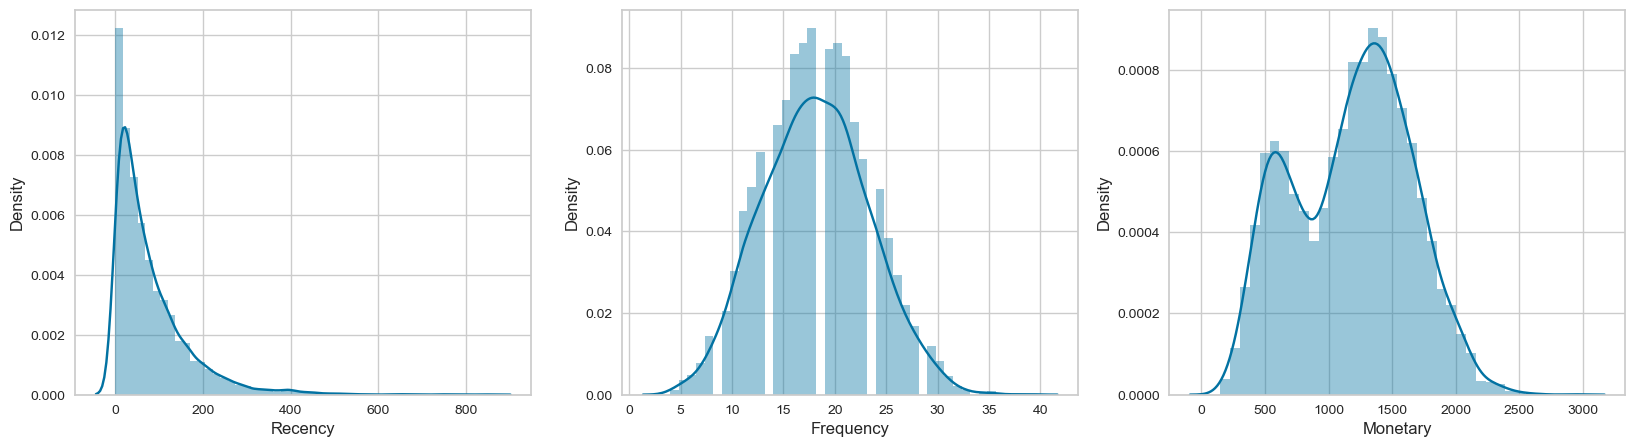

In [52]:
fig, axes = plt.subplots(1,3, figsize=(20,5))
for i, feature in enumerate (list(rfm_df.columns)):
    sns.distplot(rfm_df[feature], ax =axes[i])

Recency distribution is skewed to the right, Frequency is normal, Monetary has 2 peaks.

In [53]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,6889.000000,6889.000000,6889.000000
mean,80.538249,18.144869,1179.269705
std,85.382526,5.193014,465.832609
min,0.000000,4.000000,149.000000
25%,22.000000,14.000000,781.000000
50%,53.000000,18.000000,1227.000000
75%,111.000000,22.000000,1520.000000
max,857.000000,39.000000,2933.000000


<Axes: >

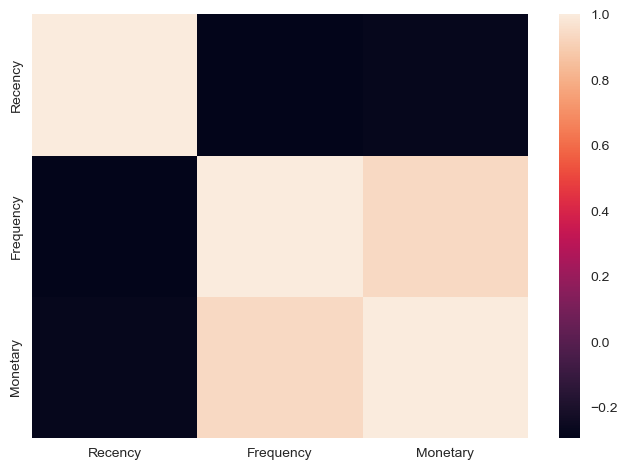

In [54]:
sns.heatmap(rfm_df.iloc[:,0:3].corr())

Frequency has a strong correlation with Monetary.


## Step 3: Data Standardizing 

The variable ranges have high variability. K-Means algorithm relies on distances, so the ranges need to be adjusted to avoid biased models.

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_std = pd.DataFrame(scaler.fit_transform(rfm_df))
rfm_std.columns = ['s_Recency','s_Frequency','s_Monetary']

In [56]:
rfm_std.describe()

,s_Recency,s_Frequency,s_Monetary
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,-5.775932e-17,3.300532e-16,-3.300532e-17
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-9.433323e-01,-2.724024e+00,-2.211834e+00
25%,-6.856496e-01,-7.982203e-01,-8.550252e-01
50%,-3.225513e-01,-2.789885e-02,1.024698e-01
75%,3.567939e-01,7.424226e-01,7.314967e-01
max,9.094579e+00,4.016289e+00,3.764995e+00


## Step 4: Segmenting with K-Means

Calculate the optimal K value using Inertia score, Silhouette score, and Calinski-Harabasz score.
These three scores are compared to determine the best one.

c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


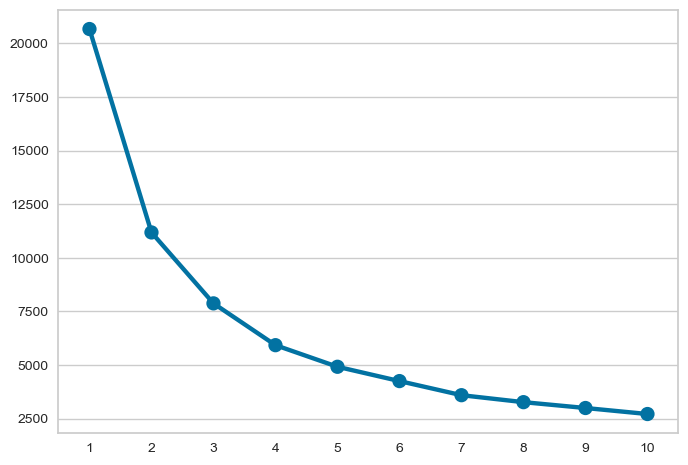

In [57]:
from sklearn.cluster import KMeans
sse=[]

for k in range(0, 10):
    kmeans = KMeans(n_clusters=k+1, max_iter=1000, random_state=42).fit(rfm_std)
    sse.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)), y=sse)
plt.show()

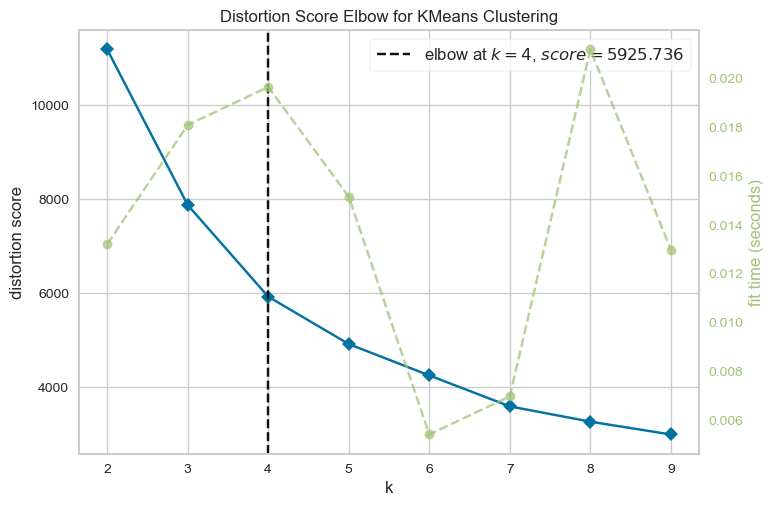

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [58]:
from yellowbrick.cluster import KElbowVisualizer

# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,10), timings= True)
visualizer.fit(rfm_std)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Plot inertia against K. There is an elbow at K = 4. After K = 4, the decrease in inertia is not significant.

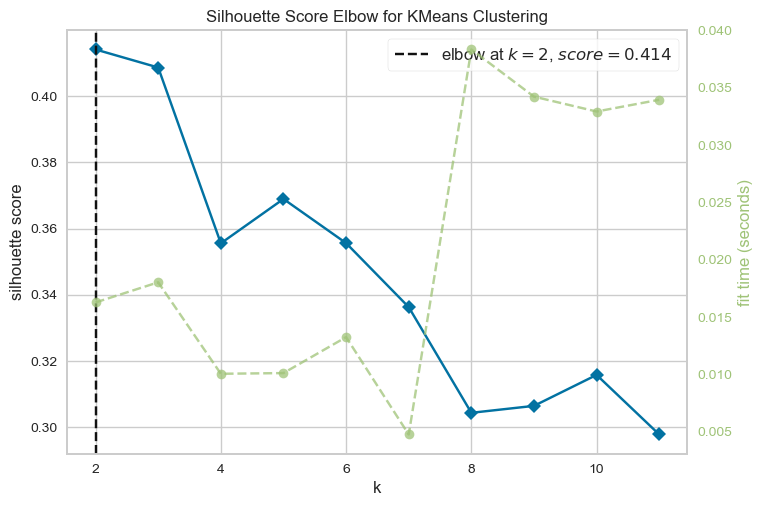

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [59]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,12),metric='silhouette', timings= True, locate_elbow=True)
visualizer.fit(rfm_std) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

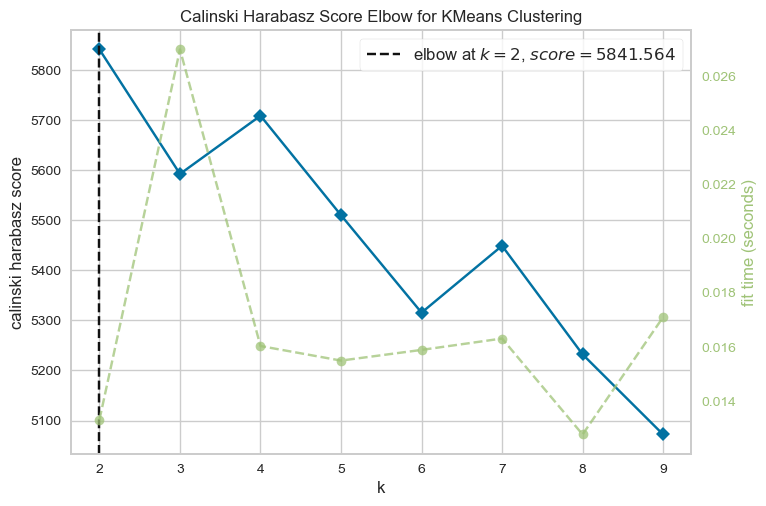

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [60]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,10),metric='calinski_harabasz', timings= True)
visualizer.fit(rfm_std)        # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

In [61]:
from yellowbrick.cluster import silhouette_visualizer

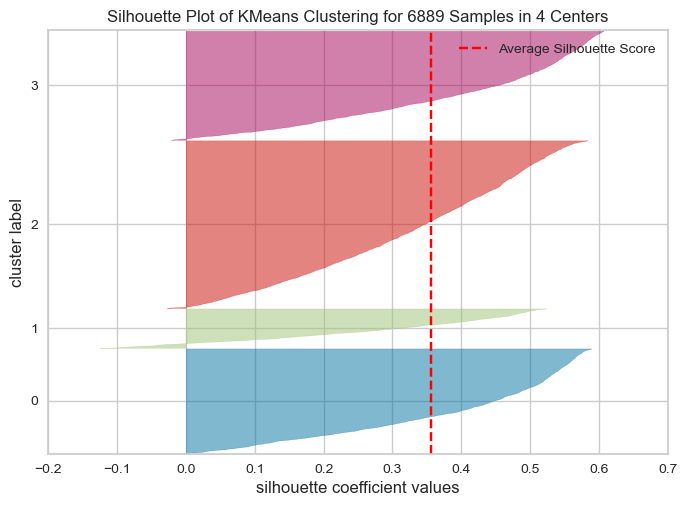

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 6889 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=42))

In [62]:
silhouette_visualizer(KMeans(4, random_state=42), rfm_std, colors='yellowbrick')

For K = 4, the width of the bar for cluster 2 appears narrower.

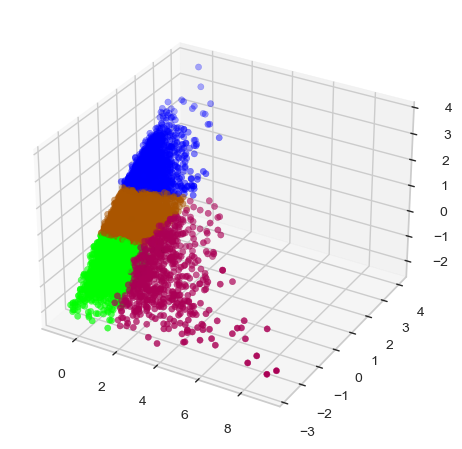

In [63]:
model = KMeans(n_clusters=4,random_state=42).fit(rfm_std)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(rfm_std['s_Recency'],rfm_std['s_Frequency'],rfm_std['s_Monetary'],cmap='brg',c=model.predict(rfm_std))
ax.scatter(centers[:,0],centers[:,1],c='black')

For K = 4, the scatter plot looks quite simple.

Next, assign clusters to each customer_id

In [64]:
rfm_ = pd.DataFrame(scaler.inverse_transform(rfm_std))
rfm_.columns = rfm_df.columns
rfm_['customer_id'] = user['customer_id']
rfm_['Cluster'] = model.labels_

In [65]:
rfm_

,Recency,Frequency,Monetary,customer_id,Cluster
0,111.0,25.0,1637.0,CS5295,0
1,1.0,26.0,1721.0,CS4768,0
2,21.0,23.0,1648.0,CS2122,0
3,77.0,20.0,1431.0,CS1217,2
4,7.0,24.0,1908.0,CS1850,0
...,...,...,...,...,...
6884,142.0,7.0,287.0,CS8478,3
6885,23.0,5.0,209.0,CS8326,3
6886,210.0,8.0,399.0,CS8409,1
6887,38.0,5.0,223.0,CS8479,3


## Step 5: Identify the clusters for further analysis

Preparing the data to create a snake plot.

c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

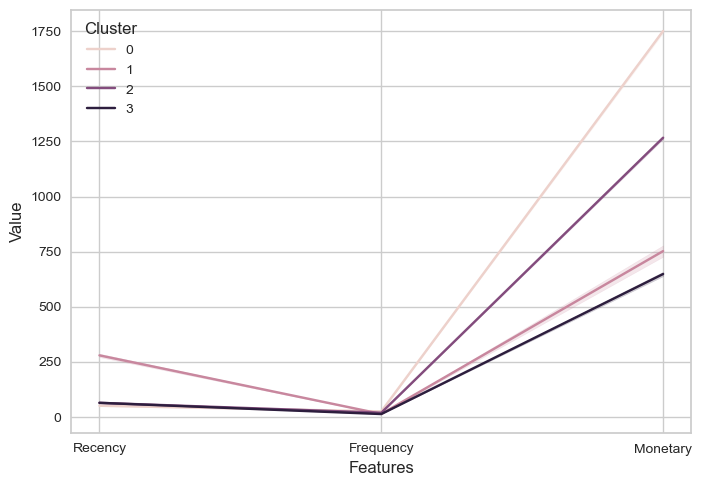

In [66]:
melted_rfm_std = pd.melt(rfm_.reset_index(),
                        id_vars = ['customer_id','Cluster'],
                        value_vars = ['Recency','Frequency','Monetary'],
                        var_name = 'Features',
                        value_name = 'Value')
sns.lineplot(x='Features',y='Value',hue='Cluster',data=melted_rfm_std)
plt.show()

In [67]:
melted_rfm_std

,customer_id,Cluster,Features,Value
0,CS5295,0,Recency,111.0
1,CS4768,0,Recency,1.0
2,CS2122,0,Recency,21.0
3,CS1217,2,Recency,77.0
4,CS1850,0,Recency,7.0
...,...,...,...,...
20662,CS8478,3,Monetary,287.0
20663,CS8326,3,Monetary,209.0
20664,CS8409,1,Monetary,399.0
20665,CS8479,3,Monetary,223.0


In [68]:
rfm_.groupby('Cluster').agg({
    'Recency':['mean','min','max'],
    'Frequency':['mean','min','max'],
    'Monetary':['mean','min','max','count']})

Recency                Frequency                 Monetary          \
               mean    min    max       mean   min   max         mean     min   
Cluster                                                                         
0         50.515734    0.0  274.0  24.784382  20.0  39.0  1751.366550  1151.0   
1        279.150388  168.0  857.0  13.193798   4.0  23.0   752.364341   157.0   
2         63.565598    0.0  239.0  18.639577  14.0  26.0  1266.997085   684.0   
3         63.714686    0.0  182.0  12.787556   4.0  19.0   648.390695   149.0   

                       
            max count  
Cluster                
0        2933.0  1716  
1        1613.0   645  
2        1667.0  2744  
3        1086.0  1784

According to the silhouette plot, cluster 1 is the smallest in size. Cluster 2 is 4 times larger than cluster 1.

From the snake plot and descriptive statistics, the best cluster is cluster 0 with the highest mean F value (most frequent purchases), the lowest mean R value (recent purchases/close to the observation date), and the highest mean M value (high purchase volume).

The cluster with the lowest values is cluster 3 with the lowest F and M values.

# RFM Scoring + K-Means

## Step 1: Assigning RFM scores.

All variables are assigned scores from 1 to 5. Standardization is not required. A score of 5-5-5 indicates the best customer, while 1-1-1 indicates the lowest value.

In [69]:
rfm2 = rfm_df.copy()
rfm2

,Recency,Frequency,Monetary
0,111,25,1637
1,1,26,1721
2,21,23,1648
3,77,20,1431
4,7,24,1908
...,...,...,...
6884,142,7,287
6885,23,5,209
6886,210,8,399
6887,38,5,223


In [70]:
s1 = np.full((1,rfm2.shape[0]-int(0.8002*rfm2.shape[0])),1)
s2 = np.full((1,int(0.20003*rfm2.shape[0])),2)
s3 = np.full((1,int(0.20003*rfm2.shape[0])),3)
s4 = np.full((1,int(0.20003*rfm2.shape[0])),4)
s5 = np.full((1,int(0.20003*rfm2.shape[0])),5)

score = np.hstack((s1,s2,s3,s4,s5)).flatten()

In [71]:
rfm2 = rfm2.sort_values(by='Recency',ascending=False)
rfm2['r_score'] = score

for i,j in zip(('Frequency','Monetary'),('f_score','m_score')):
    rfm2 = rfm2.sort_values(by=i)
    rfm2[j] = score

In [72]:
rfm2

,Recency,Frequency,Monetary,r_score,f_score,m_score
6810,181,4,149,1,1,1
5053,85,5,157,2,1,1
6832,388,4,157,1,1,1
6888,15,5,164,5,1,1
6462,218,5,181,1,1,1
...,...,...,...,...,...,...
2592,151,36,2513,1,5,5
1641,10,33,2527,5,5,5
3850,78,33,2612,2,5,5
109,80,38,2647,2,5,5


<Axes: >

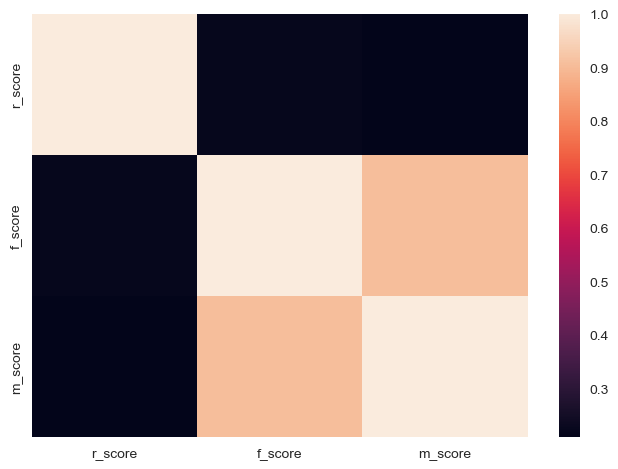

In [73]:
sns.heatmap(rfm2.iloc[:,3:6].corr())

## Step 2: Segmenting with K-Means

c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


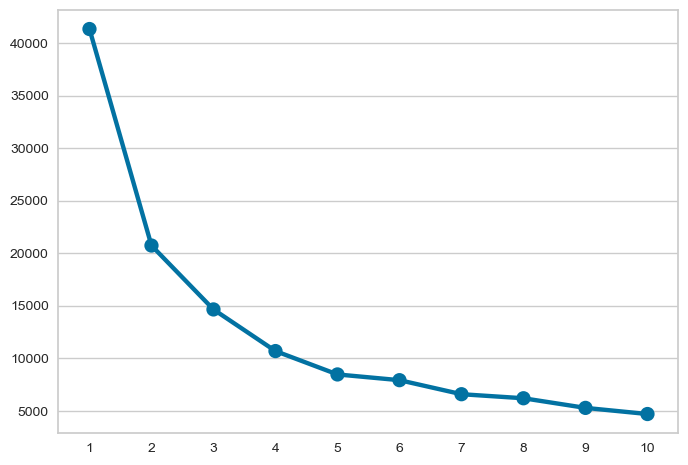

In [74]:
from sklearn.cluster import KMeans
sse=[]

for k in range(0, 10):
    kmeans = KMeans(n_clusters=k+1, max_iter=1000, random_state=42).fit(rfm2.iloc[:,3:])
    sse.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,11)), y=sse)
plt.show()

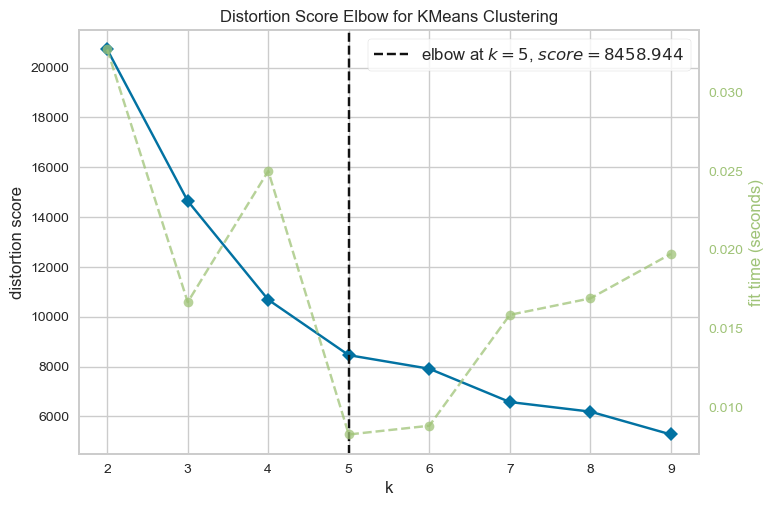

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [75]:
from yellowbrick.cluster import KElbowVisualizer

# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,10), timings= True)
visualizer.fit(rfm2.iloc[:,3:])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Plot inertia against K. There is an elbow at K = 4. After K = 4, the decrease in inertia is not significant.

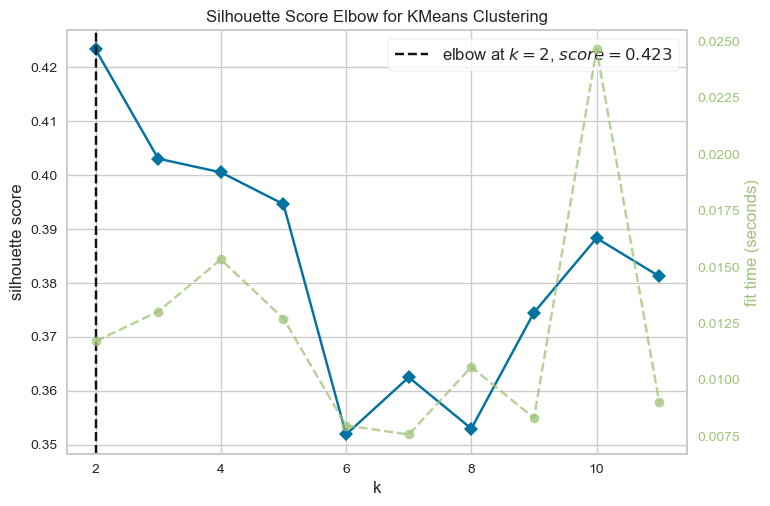

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [76]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,12),metric='silhouette',timings=True)
visualizer.fit(rfm2.iloc[:,3:])        # Fit the data to the visualizer
visualizer.show()

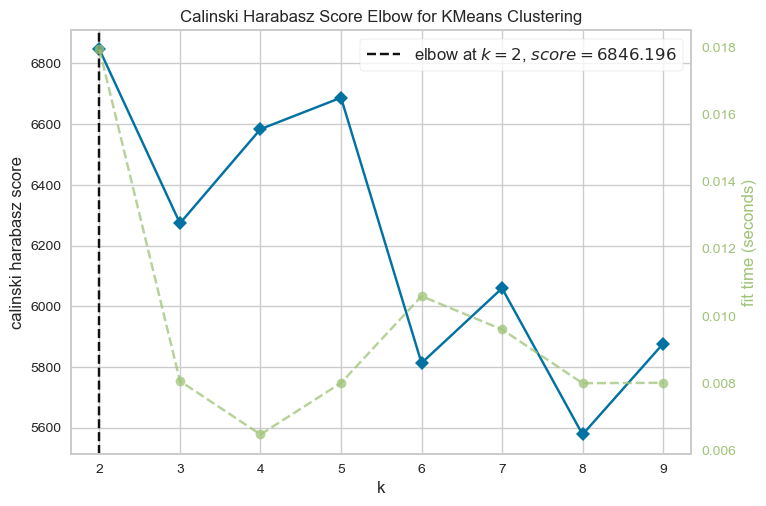

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [77]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(kmeans, k=(2,10),metric='calinski_harabasz',timings= True)
visualizer.fit(rfm2.iloc[:,3:])        # Fit the data to the visualizer
visualizer.show()

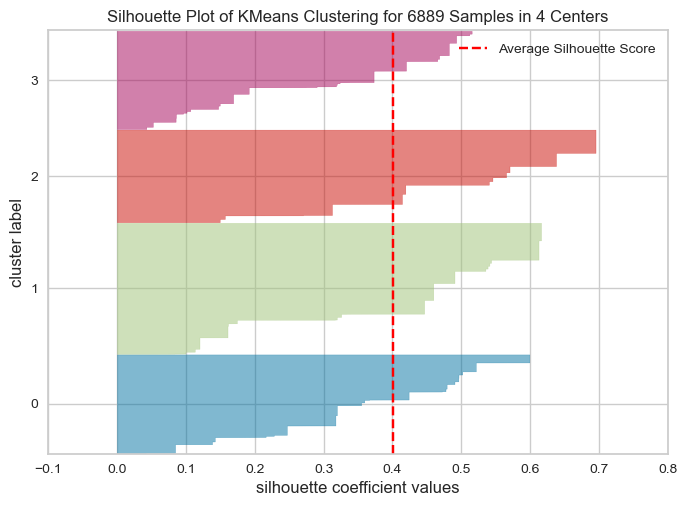

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 6889 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=4, random_state=42))

In [78]:
silhouette_visualizer(KMeans(4, random_state=42), rfm2.iloc[:,3:], colors='yellowbrick')

For K = 4, the width of the bars appears more uniform compared to standard RFM values.

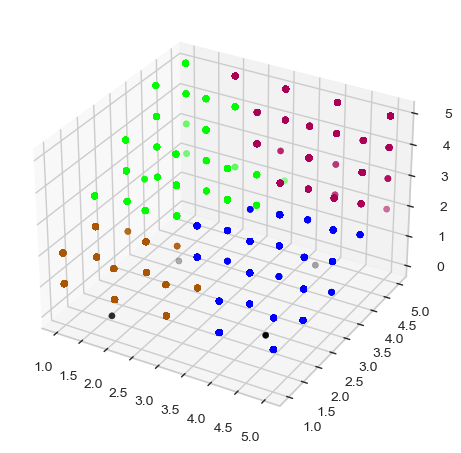

In [79]:
model = KMeans(n_clusters=4,random_state=42, init='k-means++').fit(rfm2.iloc[:,3:])
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(rfm2.iloc[:,3],
           rfm2.iloc[:,4],
           rfm2.iloc[:,5],
           cmap='brg',
           c=model.predict(rfm2.iloc[:,3:]))
ax.scatter(centers[:,0],centers[:,1],c='black')

## Step 3: Identify the clusters for further analysis.

c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\WIN10\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

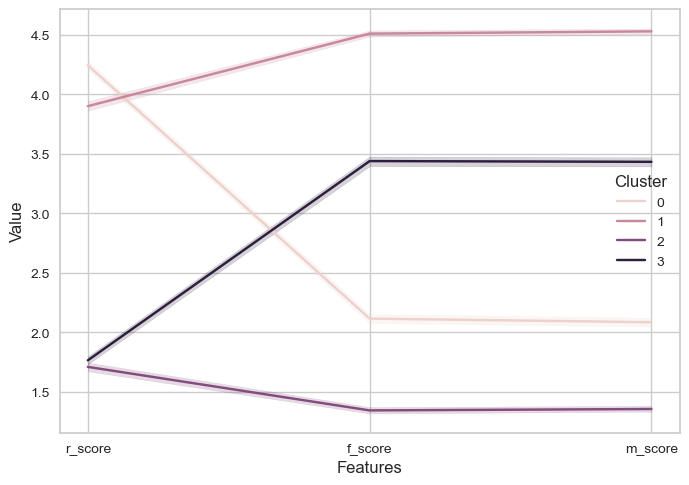

In [80]:
rfm2['Cluster'] = model.labels_

melted_rfm = pd.melt(rfm2.reset_index(),
                        id_vars = ['Cluster'],
                        value_vars = ['r_score','f_score','m_score'],
                        var_name = 'Features',
                        value_name = 'Value')
sns.lineplot(x='Features',y='Value',hue='Cluster',data=melted_rfm)
plt.show()

In [81]:
rfm2.groupby('Cluster').agg({
    'Recency':['mean','min','max'],
    'Frequency':['mean','min','max'],
    'Monetary':['mean','min','max','count']})

Recency           Frequency             Monetary                  
               mean min  max       mean min max         mean   min   max count
Cluster                                                                       
0         23.824475   0   72  15.256489   5  22   910.744129   164  1357  1618
1         33.618826   0  128  23.480429  17  39  1656.254893  1026  2933  2146
2        158.564272  39  857  12.253790   4  17   635.205010   149  1094  1517
3        126.611940  39  450  19.488184  14  36  1326.166667   689  2513  1608

The difference between RFM analysis using standard values and scoring system:
- There is a strong correlation between Frequency and Monetary.
- With the scoring system, the silhouette plot produces clusters of uniform width at K = 4. This is evident in the descriptive statistics, where cluster sizes are relatively uniform.

# Hasil Segmentasi

### Best Customer : Cluster 1
>Frequent and recent shoppers, heavy Spendings
>>Action: Target customers for launching a new product.

### New Customer : Cluster 0
>Recent shoppers, low frequency and spendings.
>>Action: Strengthen relationships and services.

### Customer at Risk of Churn : Cluster 3
>Frequent and heavy spent shoppers. Haven't purchased in a while.
>>Action: Find out reasons for customer churn. Create promotions to encourage them to return to purchasing.

### Lost Customer : Cluster 2
>Low frequency and spending, also haven't purchased in a while.
>>Action: Find out reasons for customer churn. Improve product quality to prevent further losses.

# Conclusion:
- RFM analysis can quickly segment customers into homogeneous groups with few variables.

- The scoring system allows for assigning different scoring definitions.

- Clustering with the scoring system produces more uniform clusters.

Next Steps:
Further analyze cluster 1 (highest RFM value) to uncover more insights.